<a href="https://colab.research.google.com/github/harperd17/cloud_classification/blob/main/modeling/pretrained_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook uses existing architectures to train the model from the pretrained weights.

The reason for using pretrained weights is because with the complexity of the models, it would be quite difficult to get to a good level of model performance starting from a random weight selection. The pretrained weights likely pick up on features that are important across many domains, so pretrained weights seem like a good place to start. I will not freeze any of the layers because I have over 5,000 training images, which I think should be sufficient for fine tuning the weights. If I had less data I would freeze all layers except the last layer.

In [ ]:
!git clone https://github.com/harperd17/cloud_classification.git

Cloning into 'cloud_classification'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 140 (delta 24), reused 0 (delta 0), pack-reused 84
Receiving objects: 100% (140/140), 11.17 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
!pip install torchsat
from torchsat.transforms import transforms_seg

     |████████████████████████████████| 46 kB 1.9 MB/s 


In [ ]:
import torch
import torchvision
import glob
from PIL import Image
import cv2
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 58 kB 7.9 MB/s 
     |████████████████████████████████| 376 kB 24.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=91d3ba1b4c277d67349a473651e16e53e864019cc5ff5ae6e63780d9597696af
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=95b7f0f92415d80cf51963b1e82a72dff1e1ca028f8ad95ea6c5dee94300ba08
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
drive._mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!git clone https://github.com/EdwardRaff/Inside-Deep-Learning.git
%run /content/Inside-Deep-Learning/idlmam.py

Cloning into 'Inside-Deep-Learning'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 34 (delta 10), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
from tqdm.autonotebook import tqdm
from cloud_classification.helpers.helper_functions import CloudData, show_image_and_masks, decode_pixels, train_network, show_predicted_masks, get_accuracy, get_auc

from sklearn.metrics import roc_curve, auc

## Set up the Directory for the Images

In [ ]:
data_dir = '/content/drive/Shareddrives/DavidHarper_Data690_Project/Data/train_images'
data_dir = '/content/drive/MyDrive/Data690/Project/Data'

## Load the train.csv which holds the file names, classifications, and mask information

In [ ]:
train_data = pd.read_csv(data_dir+'/train.csv')

In [ ]:
# now random sample from the train_data so that I don't have to train these networks on such a large amount of data - the final model should be trained with all the data though
image_names = pd.Series([parts[0] for parts in train_data['Image_Label'].str.split('_')])
sampled = pd.Series(pd.Series(image_names).unique()).sample(250)
train_data_sampled = train_data[image_names.isin(sampled)]

## Do a Train / Validation Split

In [ ]:
train_valid_images, test_images = train_test_split(sampled,train_size=0.9)
train_images, valid_images = train_test_split(train_valid_images,train_size=0.8)

In [ ]:
test = train_data[image_names.isin(test_images)]
train = train_data[image_names.isin(train_images)]
valid = train_data[image_names.isin(valid_images)]

## Create the CloudData objects and DataLoaders

In [ ]:
# output_width=512
# output_height=512

# test_dataset = CloudData(data_dir, test, output_width=output_width, output_height=output_height)#, transform=transform_list)
# train_dataset = CloudData(data_dir, train, output_width=output_width, output_height=output_height)#, transform=transform_list)
# valid_dataset = CloudData(data_dir, valid, output_width=output_width, output_height=output_height)#, transform=transform_list)

# print("There are {} test images".format(len(test_dataset)))
# print("There are {} train images".format(len(train_dataset)))
# print("There are {} valid images".format(len(valid_dataset)))

# batch_size = 8

# test_loader = DataLoader(test_dataset,batch_size=batch_size)
# train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset,batch_size=batch_size)

There are 25 test images
There are 180 train images
There are 45 valid images


## Get the GPU Device Configured

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Modeling

I tried using different num_filters and encoder_depths. The results for all my trials were different, but all of them weren't really good. The example below only uses an encoder depth of 34 and 32 filters since it took less time to reproduce when retraining.

In [ ]:
from torchsat.models.segmentation import unet

In [ ]:
pretrained_unet_resnet = unet.UNetResNet(encoder_depth = 34, num_classes=4, in_channels=3, num_filters=32,dropout_2d=0.3,pretrained=True)

In [ ]:
# class CloudData(Dataset):
#   """This class is used for the cloud data"""
#   def __init__(self, data_directory = None, mask_df = None, data_type = 'train', transform=None, output_width=256, output_height=256, normalize_func = None, preprocessing=None):
#     """Instantiate the CloudData object.
    
#     Arguments
#     ---------
#     data_directory (str) - path of where the images are saved. Defaults to None.
    
#     mask_df (pd.DataFrame) - the dataframe of the training data image names and labels, and encoded pixels. Defaults to None.
    
#     data_type (str) - whether the data is of type train or test. If it is test, there is no mask information and only the images are gathered. Defaults to "train".
    
#     transform (torch.transforms) - pytorch transform(s) to have applied to the images. Defaults to BASIC_TRANSFORM which simply converts image to tensor.
    
#     output_width (int) - the width to have the image tensor and masks outputted at.
    
#     output_height (int) - the height to have the image tensor and masks outputted at.
#     """
#     super(CloudData,self).__init__()
#     # the Image_Label field in the mask_df is a string with format {image_name}_{image_label} and need to be broken into two pieces
#     mask_df['Label'] = [parts[1] for parts in mask_df['Image_Label'].str.split('_')]
#     mask_df['Image'] = [parts[0] for parts in mask_df['Image_Label'].str.split('_')]
#     # we are only interested in having one item per unique image and the output for each image will be one mask per class
#     self.unique_images = mask_df['Image'].unique()
#     self.mask_df = mask_df
#     # we need to know the list of unique classes
#     self.classes = list(mask_df['Label'].unique())
#     self.data_type = data_type
#     self.data_directory = data_directory
#     self.transform = transform
#     self.normalize_func = normalize_func
#     self.preprocessing = preprocessing

#   def __getitem__(self, idx):
#     # get the image name
#     image_name = self.unique_images[idx]
#     idx_images = self.mask_df[self.mask_df['Image']==image_name]
#     # decode the "EncodedPixels" into the mask for each of the classes
#     masks = []
#     for c in self.classes:
#       mask_subset = idx_images[idx_images['Label']==c]
#       if mask_subset.shape[0] > 0:
#         masks.append(torch.tensor(decode_pixels(mask_subset.iloc[0]['EncodedPixels'], label=1)))
#       else:
#         masks.append(torch.tensor(decode_pixels(np.nan)))
    
#     # get the actual image
#     image = Image.open(self.data_directory+'/train_images/'+image_name)
#     image_tensor = torchvision.transforms.ToTensor()(image)
#     del image # save memory
#     resized_image = (F.interpolate(image_tensor.unsqueeze(0), (output_width, output_height))).squeeze(0).float()
#     resized_mask = (F.interpolate(torch.stack(masks).unsqueeze(0), (output_width, output_height))).squeeze(0).float()
#     if self.preprocessing:
#       preprocessed = self.preprocessing(image=resized_image, mask=resized_mask)
#       resized_img = preprocessed['image']
#       resized_mask = preprocessed['mask']
#     if self.transform is None:
#       if self.normalize_func is None:
#         return resized_image, resized_mask
#       else:
#         return_img, return_mask = self.normalize_func(resized_image, resized_mask)
#         return return_img, return_mask.float()
#     else:
#       if self.normalize_func is None:
#         return_img, return_mask = self.perform_transform(resized_image, resized_mask,self.transform)
#         return return_img, return_mask.float()
#       else:
#         return_img, return_mask = self.normalize_func(self.perform_transform(resized_image,resized_mask,self.transform))
#         return return_img, return_mask.float()

#     #return resized_image.squeeze(0).float(), resized_mask.squeeze(0).float()

#   def __len__(self):
#     return len(self.unique_images)

#   def perform_transform(self,img, mask, transform_list):
#     img = (img.permute(1,2,0).numpy()*255).astype(np.uint8)
#     mask = (mask.permute(1,2,0).numpy()*255).astype(np.uint8)
#     transformed_img, transformed_mask = transforms_seg.Compose(
#         transform_list
#     )(img, mask)                                                                                               
#     return torch.tensor(transformed_img/255,dtype=torch.float32).permute(2,0,1), torch.tensor(transformed_mask/255,dtype=torch.float32).permute(2,0,1)
  

In [ ]:
normalize_func = transforms_seg.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

output_width=512
output_height=512

test_dataset = CloudData(data_dir, test, normalize_func = normalize_func, output_width=output_width, output_height=output_height)#transform=transform_list)
train_dataset = CloudData(data_dir, train, normalize_func = normalize_func, output_width=output_width, output_height=output_height)#transform=transform_list)
valid_dataset = CloudData(data_dir, valid, normalize_func = normalize_func, output_width=output_width, output_height=output_height)#transform=transform_list)

print("There are {} test images".format(len(test_dataset)))
print("There are {} train images".format(len(train_dataset)))
print("There are {} valid images".format(len(valid_dataset)))

batch_size = 12

test_loader = DataLoader(test_dataset,batch_size=batch_size)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size)

In [ ]:
device

device(type='cuda')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
unet_resnet_model = unet.UNetResNet(encoder_depth = 34, num_classes=4, in_channels=3, num_filters=32,dropout_2d=0.25,pretrained=True)


optimizer = torch.optim.Adam(unet_resnet_model.parameters())
loss_func = nn.CrossEntropyLoss() # for some reason, this works much better than the Dice loss so I'm using Cross Entropy instead

In [ ]:
unet_resnet_results = train_network(unet_resnet_model, loss_func, train_loader, epochs=15, device=device, val_loader=valid_loader, optimizer=optimizer, score_funcs={'Accuracy':get_accuracy,'AUC':get_auc})

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

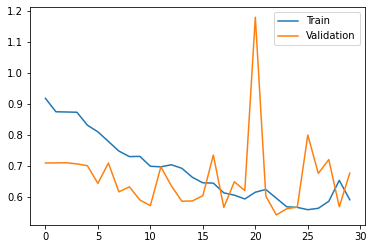

In [ ]:
plt.plot(unet_resnet_results['train loss'],label='Train')
plt.plot(unet_resnet_results['val loss'],label='Validation')
plt.legend();

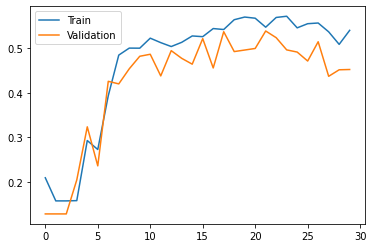

In [ ]:
plt.plot(unet_resnet_results['train Accuracy'],label='Train')
plt.plot(unet_resnet_results['val Accuracy'],label='Validation')
plt.legend();

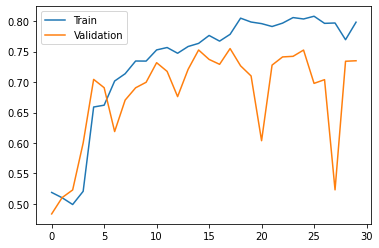

In [ ]:
plt.plot(unet_resnet_results['train AUC'],label='Train')
plt.plot(unet_resnet_results['val AUC'],label='Validation')
plt.legend();

In [ ]:
unet_resnet_model = unet_resnet_model.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 864x1296 with 42 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f7a7c7550>,
       dtype=object))

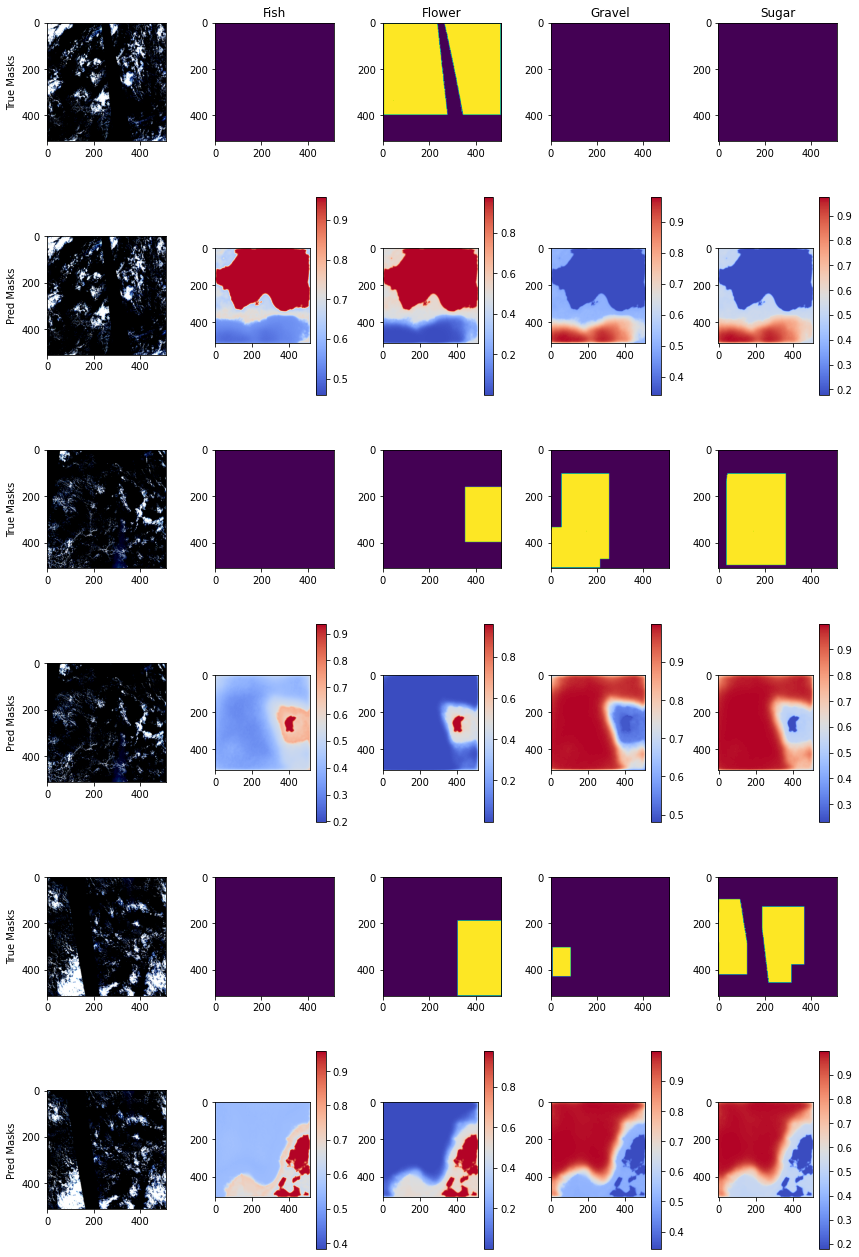

In [ ]:
to_show = 3
with torch.no_grad():
  sample_predictions = [unet_resnet_model(train_dataset[i][0].unsqueeze(0)).squeeze(0) for i in range(to_show)]
  sample_masks = [train_dataset[i][1] for i in range(to_show)]
  original_images = [train_dataset[i][0].permute(1,2,0) for i in range(to_show)]
show_predicted_masks(sample_predictions,sample_masks, original_images,classes=train_dataset.classes);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


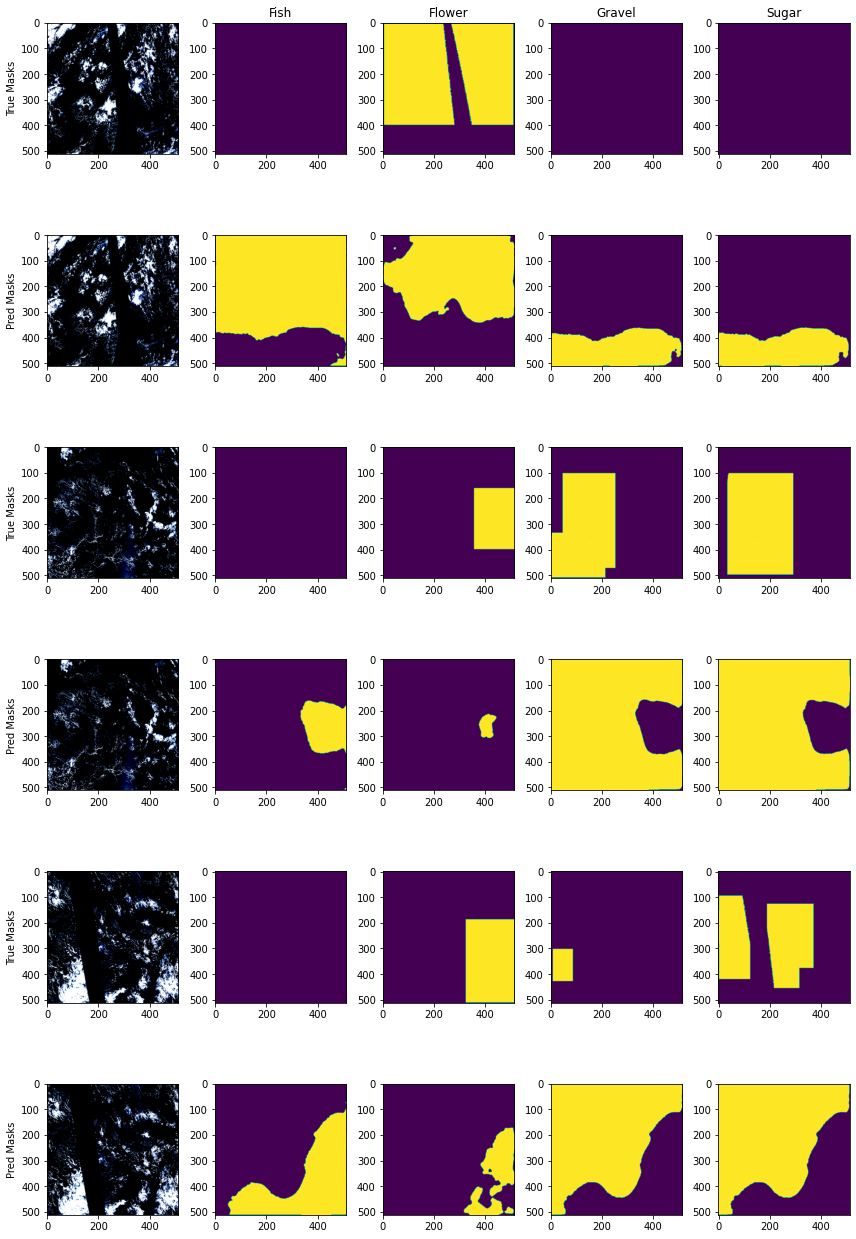

In [ ]:
# now show what the predicted mask is using a threshold
thresh = 0.5
sample_pred_masks = [(s>thresh).float() for s in sample_predictions]
show_predicted_masks(sample_pred_masks,sample_masks, original_images,classes=train_dataset.classes,cmap=None);

# Trying out a model from Segmentation Models library

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None#'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model_resnet_imagenet = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS) # this isn't used - it's the same as the normalize_func in the cell below

In [ ]:
normalize_func = transforms_seg.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

output_width=512
output_height=512

test_dataset = CloudData(data_dir, test, output_width=output_width, output_height=output_height, normalize_func = normalize_func)
train_dataset = CloudData(data_dir, train, output_width=output_width, output_height=output_height, normalize_func = normalize_func)
valid_dataset = CloudData(data_dir, valid, output_width=output_width, output_height=output_height, normalize_func = normalize_func)

batch_size = 12

test_loader = DataLoader(test_dataset,batch_size=batch_size)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size)

In [ ]:
loss_func = smp.losses.DiceLoss(mode='multilabel')
optimizer = torch.optim.Adam(model_resnet_imagenet.parameters())

In [ ]:
results = train_network(model_resnet_imagenet, loss_func, train_loader, epochs=15, device=device, val_loader=valid_loader, optimizer=optimizer, score_funcs={'Accuracy':get_accuracy,'AUC':get_auc})

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]

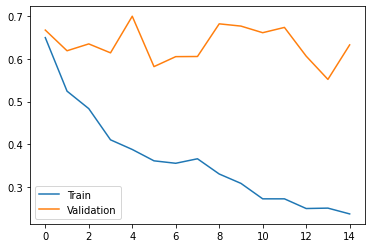

In [ ]:
plt.plot(results['train loss'],label='Train')
plt.plot(results['val loss'],label='Validation')
plt.legend();

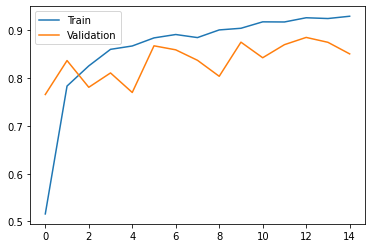

In [ ]:
plt.plot(results['train Accuracy'],label='Train')
plt.plot(results['val Accuracy'],label='Validation')
plt.legend();

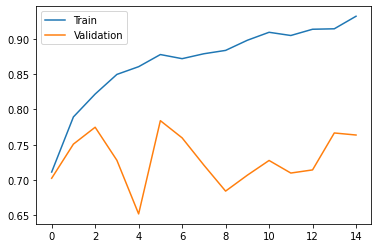

In [ ]:
plt.plot(results['train AUC'],label='Train')
plt.plot(results['val AUC'],label='Validation')
plt.legend();

In [ ]:
model_resnet_imagenet = model_resnet_imagenet.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


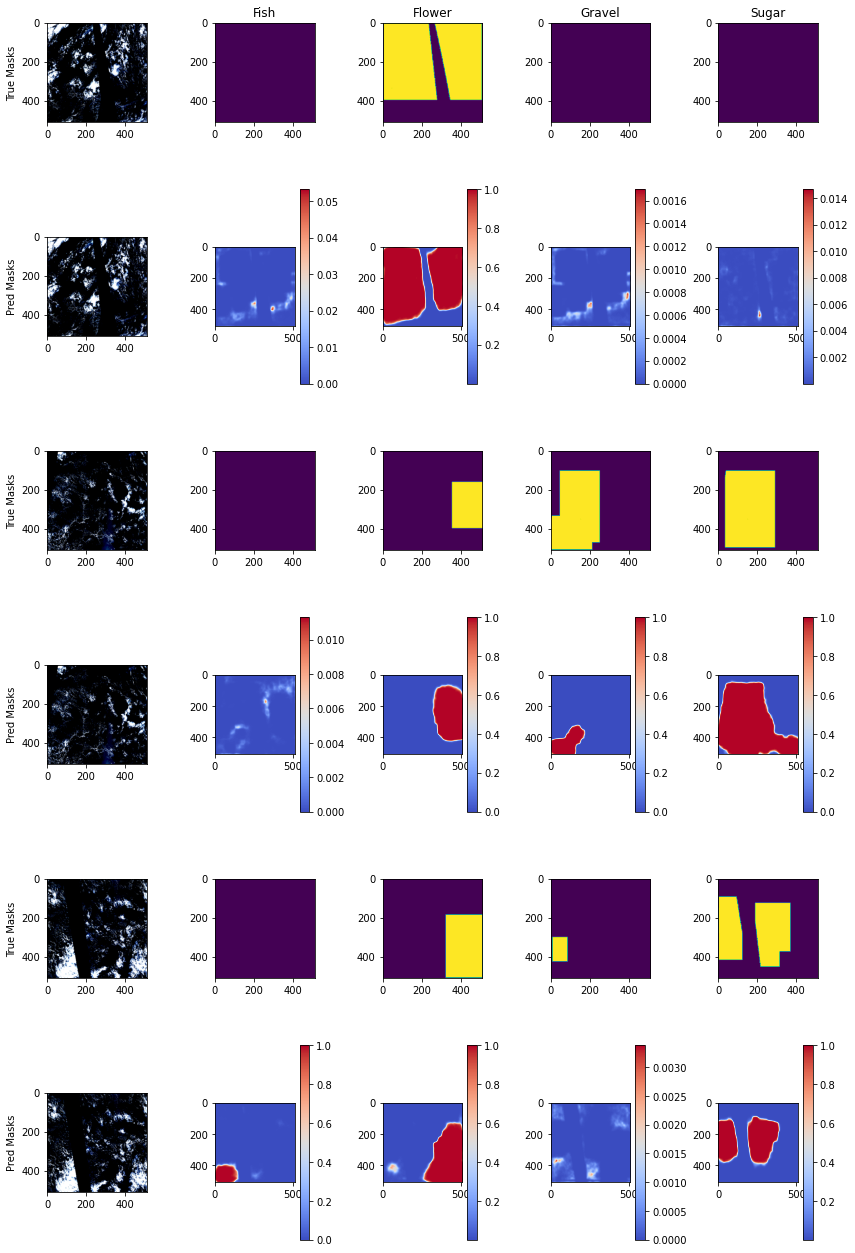

In [ ]:
to_show = 3
with torch.no_grad():
  sample_predictions = [model_resnet_imagenet(train_dataset[i][0].unsqueeze(0)).squeeze(0) for i in range(to_show)]
  sample_masks = [train_dataset[i][1] for i in range(to_show)]
  original_images = [train_dataset[i][0].permute(1,2,0) for i in range(to_show)]
show_predicted_masks(sample_predictions,sample_masks, original_images,classes=train_dataset.classes);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


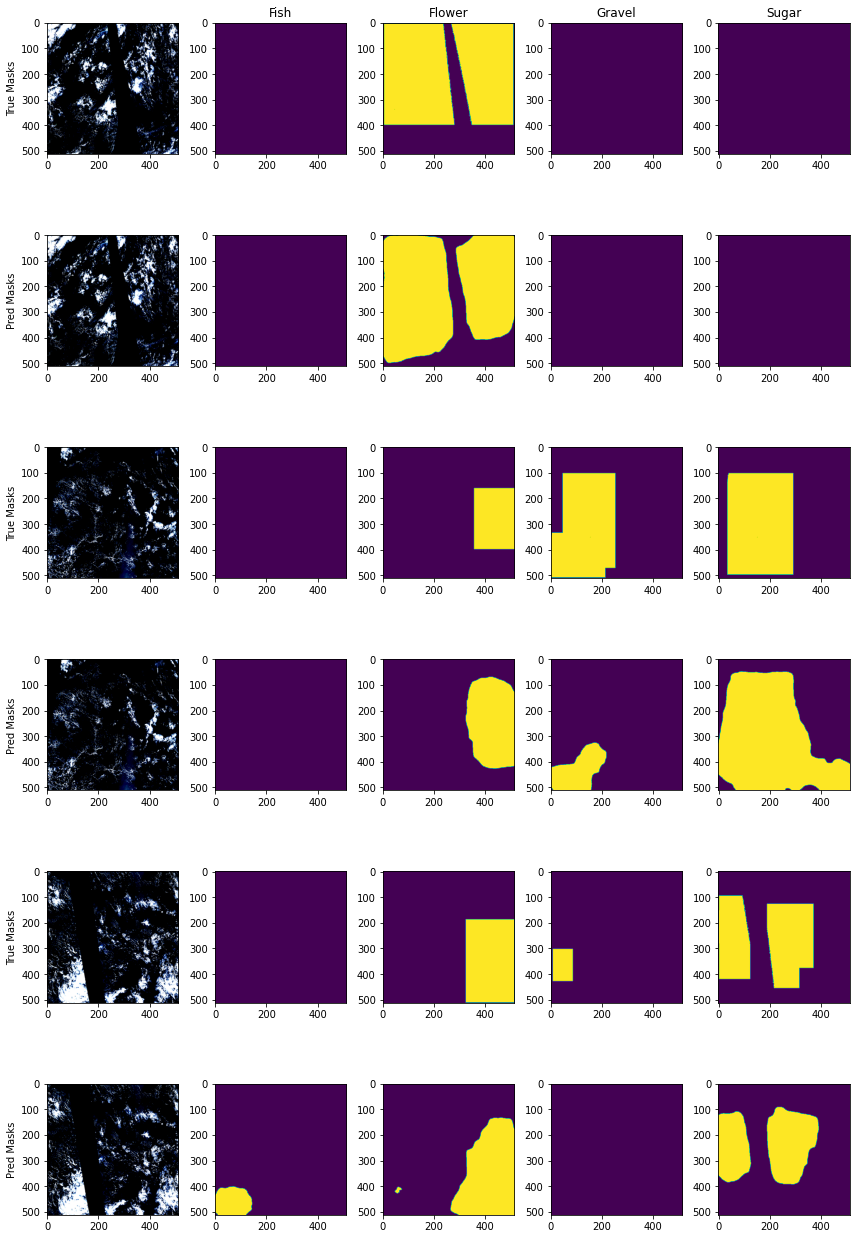

In [ ]:
# now show what the predicted mask is using a threshold
thresh = 0.5
sample_pred_masks = [(s>thresh).float() for s in sample_predictions]
show_predicted_masks(sample_pred_masks,sample_masks, original_images,classes=train_dataset.classes,cmap=None);